In [1]:
pip install lightly mambavision transformers mamba_ssm timm

  Using cached mambavision-1.0.9-py3-none-any.whl.metadata (13 kB)
  Using cached timm-0.9.0-py3-none-any.whl.metadata (68 kB)
  Using cached mamba_ssm-1.0.1.tar.gz (28 kB)
  Preparing metadata (setup.py) ... done
  Using cached causal_conv1d-1.0.2.tar.gz (6.4 kB)
  Preparing metadata (setup.py) ... done
  Using cached buildtools-1.0.6-py3-none-any.whl
  Using cached SQLAlchemy-2.0.38-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.6 kB)
  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached twisted-24.11.0-py3-none-any.whl.metadata (20 kB)
  Using cached simplejson-3.20.1-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)
  Using cached furl-2.1.3-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached docopt-0.6.2-py2.py3-none-any.whl
  Using cached redo-3.0.0-py2.py3-none-any.whl.metadata (8.0 kB)
  Using cached orderedmultidict-1.0.1-py2.py3-none-any.whl.metadata (1.3 

**Import Libraries**

In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import timm

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from lightly.loss import NTXentLoss
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Define parameters
SEED = 42

# Parameteres fine tuning
LEARNING_RATE = 1e-2
TEST_SIZE = 0.8
EPOCHS = 6
BATCH_SIZE = 32

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Ensure deterministic behavior in CUDA operations
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data (Stage 1)**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)
    print(f"Data extracted to {extracted_path}")

# Uncomment the line below to extract data (if not already extracted)
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing (Stage 1)**

In [6]:
# Define Disease Labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

def load_labels(csv_path, image_path):
    """
    Loads and preprocesses the labels from the CSV file.
    Maps each image to its corresponding file path and binary labels for each disease.
    """

    # Read the CSV file containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create a binary column for 'No Finding'
    labels_df['No_Finding'] = labels_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

    # Map image filenames to their full paths
    image_paths = glob(os.path.join(image_path, '**', 'images', '*.png'), recursive=True)
    img_path_dict = {os.path.basename(path): path for path in image_paths}

    # Add the full image path to the dataframe
    labels_df['Path'] = labels_df['Image Index'].map(img_path_dict)
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
labels_df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Remove all No finding labels for stage 1 training
labels_df_stage_2 = labels_df
labels_df = labels_df[labels_df['No_Finding'] != 1]

# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 41466
Test size: 10293


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Custom Dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),
    
    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Apply random horizontal flip to augment the data
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image within a range of ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format for further transformations
    transforms.ToPILImage(),

    # Convert to grayscale and change to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize((224, 224)),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [11]:
train_size = int(TEST_SIZE * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [12]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

# **Step 3: Build the Model (Stage 1)**

In [13]:
pip install mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


**Initialize the Multi-Label Classifier Model**

In [14]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, num_classes=len(disease_labels), model_name="nvidia/MambaVision-T2-1K"):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Vision Mamba model
        self.base_model = AutoModel.from_pretrained(model_name, trust_remote_code=True)

        print(self.base_model)

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier()
model.to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


2025-03-03 17:00:00.949592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741017602.645470  875675 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741017603.576021  875675 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 17:00:08.279619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


MambaVisionModel(
  (model): MambaVision(
    (patch_embed): PatchEmbed(
      (proj): Identity()
      (conv_down): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (levels): ModuleList(
      (0): MambaVisionLayer(
        (blocks): ModuleList(
          (0): ConvBlock(
            (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): GELU(approximate='tanh')
            (conv2): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Define Loss Function and Optimizer**

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# **Step 4: Train the Model (Stage 1)**

**Step 1: Train Classification Head Only**

In [16]:
# Freeze the backbone parameters
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

In [17]:
# Only the classifier parameters will be updated
optimizer_head = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
criterion = nn.BCEWithLogitsLoss()
scheduler = optim.lr_scheduler.StepLR(optimizer_head, step_size=2, gamma=0.1)

In [18]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler once per epoch.
        scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_head, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 260/260 [00:20<00:00, 12.59it/s, Loss=0.329]


Epoch 1/6 | Training Loss: 0.3148 | Validation Loss: 0.2983 | Mean Validation AUC: 0.6538


Epoch 2/6: 100%|██████████| 260/260 [00:15<00:00, 17.07it/s, Loss=0.359]


Epoch 2/6 | Training Loss: 0.3007 | Validation Loss: 0.2967 | Mean Validation AUC: 0.6588


Epoch 3/6: 100%|██████████| 260/260 [00:15<00:00, 16.33it/s, Loss=0.319]


Epoch 3/6 | Training Loss: 0.2883 | Validation Loss: 0.2855 | Mean Validation AUC: 0.6918


Epoch 4/6: 100%|██████████| 260/260 [00:15<00:00, 16.78it/s, Loss=0.337]


Epoch 4/6 | Training Loss: 0.2850 | Validation Loss: 0.2845 | Mean Validation AUC: 0.6955


Epoch 5/6: 100%|██████████| 260/260 [00:15<00:00, 16.43it/s, Loss=0.326]


Epoch 5/6 | Training Loss: 0.2838 | Validation Loss: 0.2838 | Mean Validation AUC: 0.6965


Epoch 6/6: 100%|██████████| 260/260 [00:15<00:00, 16.89it/s, Loss=0.336]


Epoch 6/6 | Training Loss: 0.2827 | Validation Loss: 0.2834 | Mean Validation AUC: 0.6980


**Step 2: Fine Tune Entire Network**

In [19]:
# Unfreeze all layers for fine tuning
for param in model.parameters():
    param.requires_grad = True

In [20]:
# Use a lower learning rate for the whole network
optimizer_full = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer_full, step_size=2, gamma=0.1)

In [21]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

        # Update the scheduler once per epoch.
        scheduler.step()

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer_full, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 260/260 [00:19<00:00, 13.38it/s, Loss=0.276]


Epoch 1/6 | Training Loss: 0.2731 | Validation Loss: 0.2627 | Mean Validation AUC: 0.7624


Epoch 2/6: 100%|██████████| 260/260 [00:17<00:00, 14.78it/s, Loss=0.262]


Epoch 2/6 | Training Loss: 0.2575 | Validation Loss: 0.2540 | Mean Validation AUC: 0.7887


Epoch 3/6: 100%|██████████| 260/260 [00:19<00:00, 13.16it/s, Loss=0.265]


Epoch 3/6 | Training Loss: 0.2442 | Validation Loss: 0.2477 | Mean Validation AUC: 0.8020


Epoch 4/6: 100%|██████████| 260/260 [00:19<00:00, 13.41it/s, Loss=0.254]


Epoch 4/6 | Training Loss: 0.2407 | Validation Loss: 0.2470 | Mean Validation AUC: 0.8036


Epoch 5/6: 100%|██████████| 260/260 [00:19<00:00, 13.23it/s, Loss=0.249]


Epoch 5/6 | Training Loss: 0.2383 | Validation Loss: 0.2464 | Mean Validation AUC: 0.8059


Epoch 6/6: 100%|██████████| 260/260 [00:19<00:00, 13.35it/s, Loss=0.231]

Epoch 6/6 | Training Loss: 0.2382 | Validation Loss: 0.2465 | Mean Validation AUC: 0.8058


# **Step 4: Data Processing (Stage 2)**

**Split Dataset**

In [22]:
# Include all labels including No finding i stage 2
labels_df = labels_df_stage_2

# Split patients into training/validation and test sets
unique_patients = labels_df['Patient ID'].unique()
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)

# Create training/validation and test dataframes
train_val_df = labels_df[labels_df['Patient ID'].isin(train_val_patients)].reset_index(drop=True)
test_df = labels_df[labels_df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {train_val_df.shape[0]}")
print(f"Test size: {test_df.shape[0]}")

Train size: 89826
Test size: 22294


**Create Datasets**

In [23]:
train_dataset = ChestXrayDataset(train_val_df, transform=train_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Split into Training and Validation**

In [24]:
train_size = int(TEST_SIZE * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

**Create DataLoaders**

In [25]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=32)

# **Step 5: Build the Model (Stage 2)**

**Initialize the Multi-Label Classifier Model**

In [36]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using Swin Transformer as the base model.
    """
    def __init__(self, model, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained Swin Transformer model
        self.base_model = model.base_model

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(model)
model.to(device)

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Define Loss Function, Optimizer and Scheduler**

In [37]:
criterion = nn.BCEWithLogitsLoss()

# Separate parameters: exclude head parameters from the base group
base_params = [p for n, p in model.base_model.model.named_parameters() if 'head' not in n]
head_params = list(model.base_model.model.head.parameters())

optimizer = optim.Adam([
    {'params': base_params, 'lr': 2e-5},  # lower learning rate for base layers
    {'params': head_params, 'lr': 8e-5}   # higher learning rate for head layers
])

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=[2e-5, 8e-5],
    total_steps=EPOCHS * len(train_loader),
    anneal_strategy='linear'
)

# **Step 6: Train the Model (Stage 2)**

In [38]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Update learning rates per batch
            scheduler.step()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())

            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Mean Validation AUC: {mean_auc:.4f}")

    return train_losses, val_losses, val_aucs

# Train the model for the desired number of epochs
train_losses, val_losses, val_aucs = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

Epoch 1/6: 100%|██████████| 562/562 [00:35<00:00, 15.75it/s, Loss=0.34] 


Epoch 1/6 | Training Loss: 0.5796 | Validation Loss: 0.3464 | Mean Validation AUC: 0.7879


Epoch 2/6: 100%|██████████| 562/562 [00:21<00:00, 25.80it/s, Loss=0.144] 


Epoch 2/6 | Training Loss: 0.2092 | Validation Loss: 0.1505 | Mean Validation AUC: 0.8118


Epoch 3/6: 100%|██████████| 562/562 [00:21<00:00, 26.52it/s, Loss=0.131] 


Epoch 3/6 | Training Loss: 0.1478 | Validation Loss: 0.1444 | Mean Validation AUC: 0.8338


Epoch 4/6: 100%|██████████| 562/562 [00:40<00:00, 13.91it/s, Loss=0.138] 


Epoch 4/6 | Training Loss: 0.1436 | Validation Loss: 0.1428 | Mean Validation AUC: 0.8380


Epoch 5/6: 100%|██████████| 562/562 [00:39<00:00, 14.06it/s, Loss=0.137] 


Epoch 5/6 | Training Loss: 0.1419 | Validation Loss: 0.1421 | Mean Validation AUC: 0.8406


Epoch 6/6: 100%|██████████| 562/562 [00:40<00:00, 14.04it/s, Loss=0.134] 


Epoch 6/6 | Training Loss: 0.1408 | Validation Loss: 0.1417 | Mean Validation AUC: 0.8439


# **Step 9: Evaluate the Model**

In [39]:
# TTA transforms using the new methods
tta_transforms = [
    lambda img: img,  # Original image
    lambda img: transforms.RandomHorizontalFlip(p=0.5)(img),
    lambda img: transforms.RandomRotation(10)(img)
]

In [40]:
def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set and returns predictions and true labels.
    """
    model.eval()
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Apply each TTA transformation and predict
            for tta in tta_transforms:
                augmented_inputs = tta(inputs)
                outputs = model(augmented_inputs)
                preds = torch.sigmoid(outputs)
                tta_preds.append(preds)

            # Average the predictions across TTA transforms
            avg_preds = torch.stack(tta_preds).mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    preds = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    return preds, labels

# Get predictions and true labels
preds, labels = evaluate_model(model, test_loader)

Evaluating on Test Set: 100%|██████████| 697/697 [02:04<00:00,  5.62it/s]


**Compute Metrics for Each Label**

In [41]:
# Initialize dictionaries for metrics
accuracy_per_label = {}
f1_per_label = {}
roc_auc_per_label = {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):
    
    # Binarize predictions with threshold 0.5
    binary_preds = preds[:, i] > 0.5

    # Calculate accuracy
    acc = accuracy_score(labels[:, i], binary_preds)

    # Calculate f1 score
    f1 = f1_score(labels[:, i], binary_preds)

    # Calculate ROC AUC
    roc_auc = roc_auc_score(labels[:, i], preds[:, i])

    # Store metrics
    accuracy_per_label[label] = acc
    f1_per_label[label] = f1
    roc_auc_per_label[label] = roc_auc

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_per_label,
    'ROC AUC': roc_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

# Print dataframe with metrics
metrics_df

,Accuracy,F1 Score,ROC AUC
Atelectasis,0.902978,0.235419,0.824444
Consolidation,0.957343,0.000000,0.818688
Infiltration,0.815197,0.195941,0.717516
Pneumothorax,0.954562,0.297016,0.892598
Edema,0.979142,0.033264,0.901651
Emphysema,0.976810,0.348045,0.926871
Fibrosis,0.983493,0.000000,0.820493
Effusion,0.902306,0.512097,0.890617
Pneumonia,0.986813,0.000000,0.754388
Pleural_Thickening,0.970440,0.003026,0.807008


**Plot ROC curves for each label**

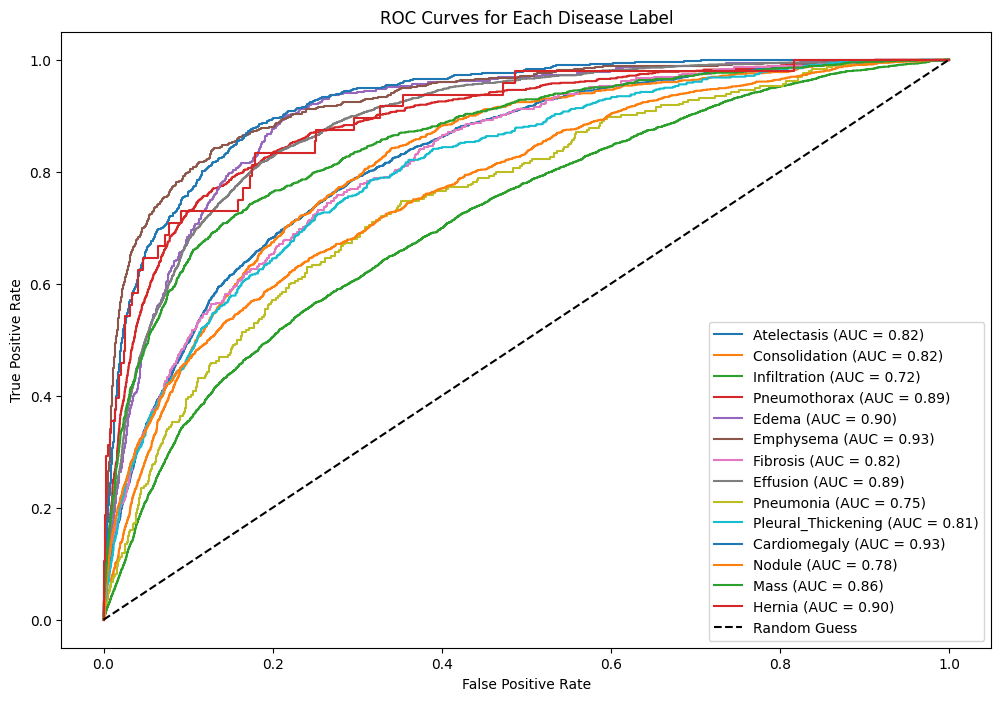

In [42]:
# Plot ROC curves
plt.figure(figsize=(12, 8))
for i, label in enumerate(disease_labels):
    fpr, tpr, _ = roc_curve(labels[:, i], preds[:, i])
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_per_label[label]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Disease Label')
plt.legend(loc='lower right')
plt.show()

**Plot Training and Validation Loss**

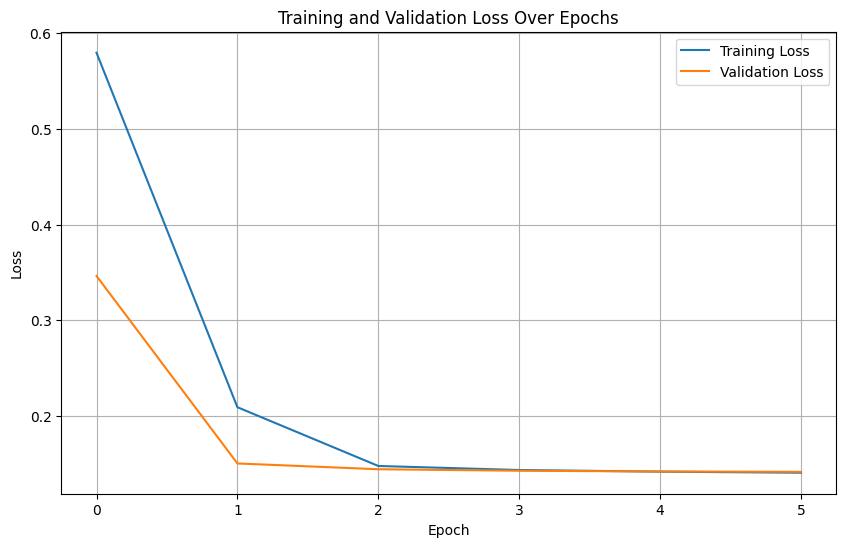

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

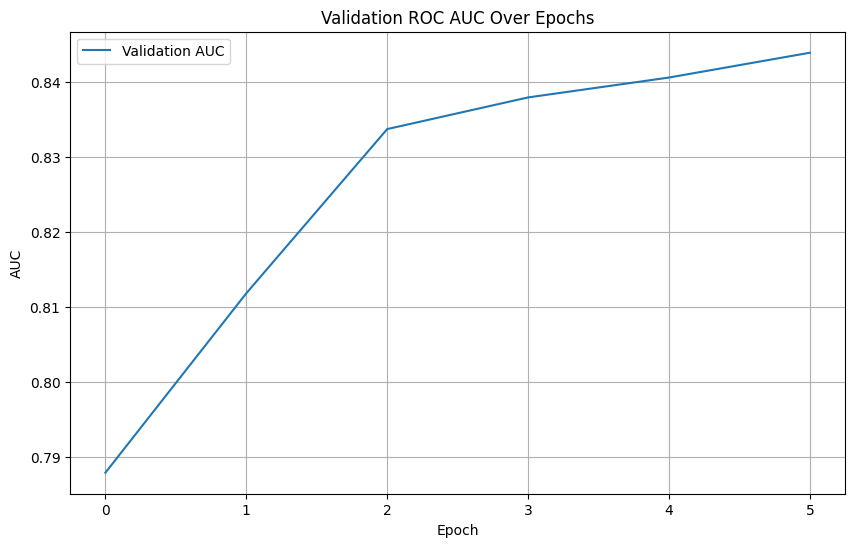

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()